# Нейроинформатика. Лабораторная работа 7
### Автоассоциативные сети с узким горлом (ака Автоэнкодеры)

Целью работы является исследование свойств автоассоциативных сетей с узким горлом, алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного анализа главных компонент набора данных.

Выполнил Моисеенков Илья, 408Б

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer
from keras import backend as back

import matplotlib.pyplot as plt

Будем работать с датасетом CIFAR-10. Загрузим его с помощью кераса

In [ ]:
train, test = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
X_train, y_train = train
X_test, y_test = test

Будем использовать картинки класса №3

In [ ]:
X_train = np.array([X_train[i] for i in range(len(X_train)) if y_train[i] == 3])
X_test = np.array([X_test[i] for i in range(len(X_test)) if y_test[i] == 3])

In [ ]:
X_train.shape, X_test.shape

((5000, 32, 32, 3), (1000, 32, 32, 3))

В нашем распоряжении 5к цветных картинок размерности 32х32 на трейне и 1к на тесте.
Посмотрим на них

In [ ]:
def plot_image(image):
    # image = np.reshape(image, (3, 32, 32))
    # image = np.transpose(image, [1, 2, 0])
    plt.imshow(image)

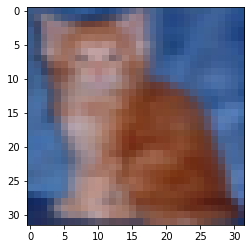

In [ ]:
plot_image(X_train[12])

Работаем с изображениями котов

Подготовим модель автоэнкодера. Автоэнкодер состоит из двух частей - энкодера и декодера. Энкодер пытается сжать изображение, а декодер восстанавливает исходное изображение из сжатого.

Будем использовать комбинацию из двух линейных слоев в энкодере и декодере. Для удобства нормируем значения изображения, чтобы они были в диапазоне от 0 до 1.

In [ ]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(32*32*3 / 4, activation='relu'),
            keras.layers.Dense(32*32*3 / 16, activation='sigmoid'),
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(32*32*3 / 4, activation='relu'),
            keras.layers.Dense(32*32*3, activation='sigmoid'),
            keras.layers.Reshape((32, 32, 3)),
        ])
    
    def call(self, input):
        input = input / 255 # [0; 255] -> [0; 1]
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded * 255 # [0; 1] -> [0; 255]
    
    def call_change_kernel_neuron(self, input, id, value):
        """
        1. Encodes picture
        2. Changes neuron value in encoded picture: encoded[id] = value
        3. Decodes picture
        """
        input = input / 255 # [0; 255] -> [0; 1]
        encoded = np.array(self.encoder(input))
        print('real values: ', encoded[:, id])
        encoded[:, id] = value
        decoded = self.decoder(encoded)
        return decoded * 255 # [0; 1] -> [0; 255]

In [ ]:
model = AutoEncoder()

Учить будем Адамом, лосс - MSE

In [ ]:
model.compile(
    loss='mse',
    optimizer='Adam',
    metrics='mae',
)

In [ ]:
train_info = model.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    batch_size=128,
    epochs=500,
    verbose=0,
)

Посмотрим на график лосса

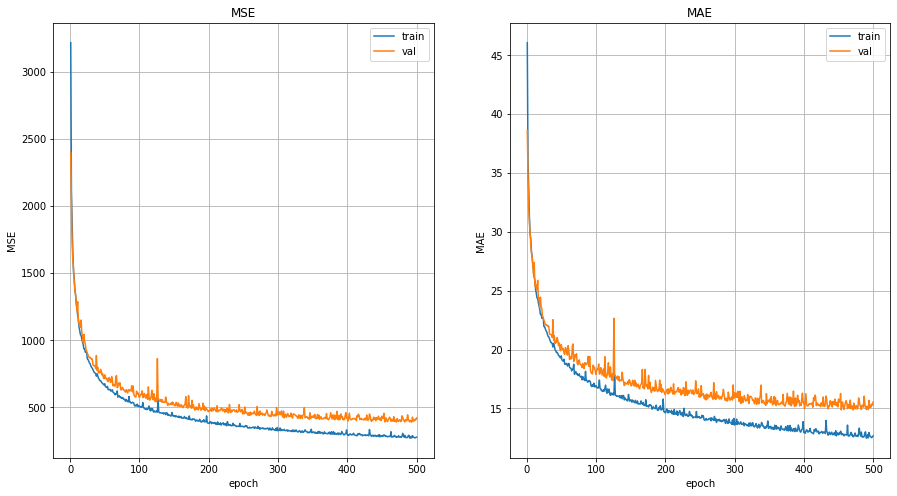

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
loss_history = train_info.history['loss']
val_loss_history = train_info.history['val_loss']
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(range(1, len(loss_history) + 1), loss_history, label='train')
plt.plot(range(1, len(loss_history) + 1), val_loss_history, label='val')
plt.grid()
plt.legend()
plt.title('MSE')

plt.subplot(1, 2, 2)
mae_history = train_info.history['mae']
val_mae_history = train_info.history['val_mae']
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.plot(range(1, len(mae_history) + 1), mae_history, label='train')
plt.plot(range(1, len(val_mae_history) + 1), val_mae_history, label='val')
plt.grid()
plt.legend()
plt.title('MAE')

plt.show()

Посмотрим на результат работы автоэнкодера на нескольких радномных картинках из трейна

In [ ]:
def plot_results(original, decoded):
    plt.figure(figsize=(20, 4))

    for i in range(10):
        # display original
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(original[i])
        plt.title("original")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(decoded[i])
        plt.title("decoded")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
random_train = X_train[np.random.choice(X_train.shape[0], 10)]
random_train_decoded = tf.cast(model(random_train), 'int32')

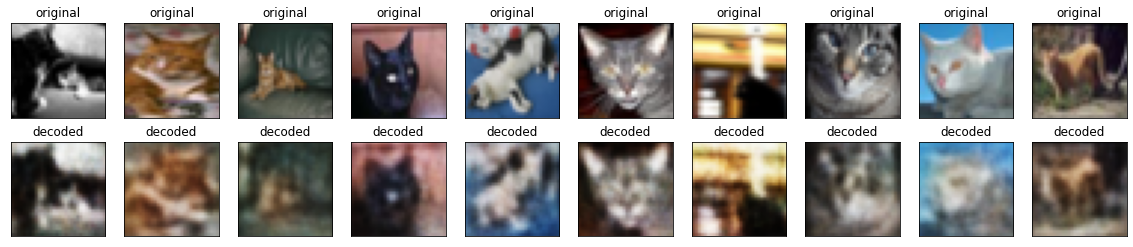

In [ ]:
plot_results(random_train, random_train_decoded)

И из теста



In [ ]:
random_test = X_test[np.random.choice(X_test.shape[0], 10)]
random_test_decoded = tf.cast(model(random_test), 'int32')

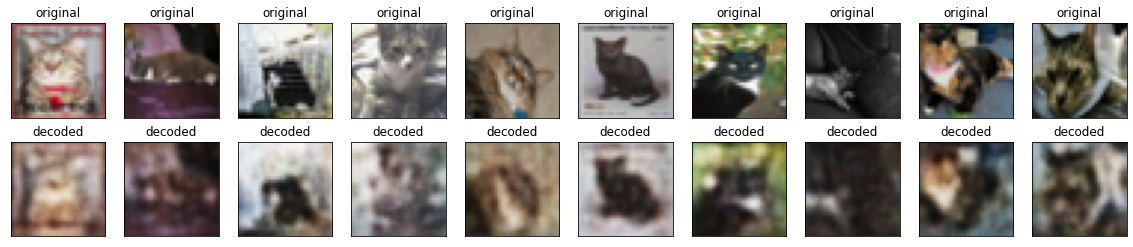

In [ ]:
plot_results(random_test, random_test_decoded)

Попробуем поменять некоторые значения в ядре картинки и посмотрим, как это повлияет на результат автоэнкодера

In [ ]:
random_test_decoded1 = tf.cast(model.call_change_kernel_neuron(random_test, 100, -100), 'int32')
random_test_decoded2 = tf.cast(model.call_change_kernel_neuron(random_test, 100, 0), 'int32')
random_test_decoded3 = tf.cast(model.call_change_kernel_neuron(random_test, 100, 100), 'int32')

real values:  [0.3203335  0.4593613  0.56421614 0.21898977 0.3026756  0.4930569
 0.48718917 0.4487682  0.7070694  0.5887095 ]
real values:  [0.3203335  0.4593613  0.56421614 0.21898977 0.3026756  0.4930569
 0.48718917 0.4487682  0.7070694  0.5887095 ]
real values:  [0.3203335  0.4593613  0.56421614 0.21898977 0.3026756  0.4930569
 0.48718917 0.4487682  0.7070694  0.5887095 ]


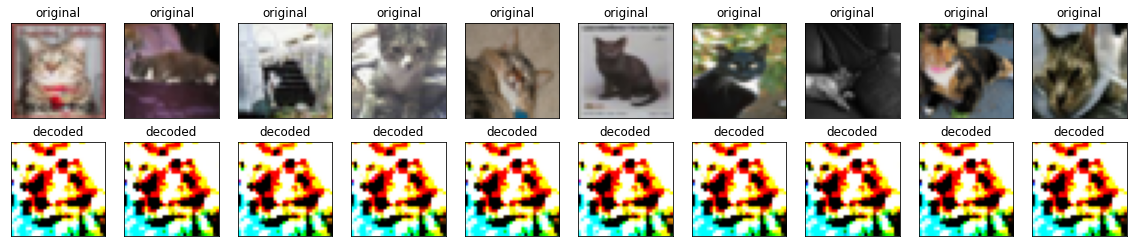

In [ ]:
plot_results(random_test, random_test_decoded1)

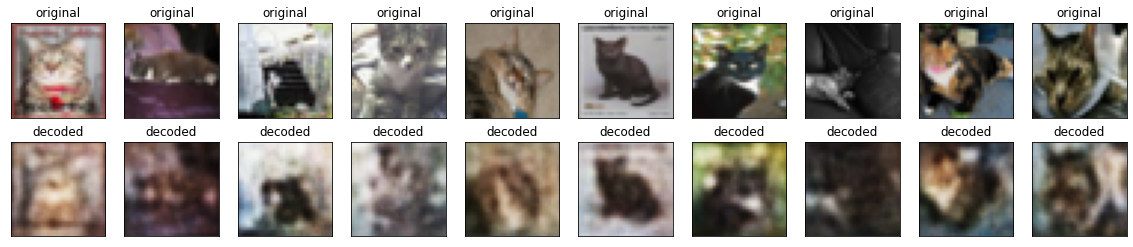

In [ ]:
plot_results(random_test, random_test_decoded2)

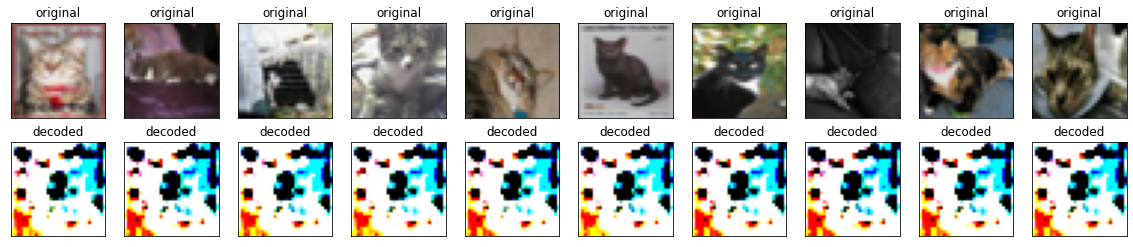

In [ ]:
plot_results(random_test, random_test_decoded3)

Видим, что при значительном изменении какого-либо параметра модель начинает рисовать непонятную фигню, причем эта фигня рисуется одинаково для всех входных изображений

Попробуем поменять значения на другой позиции. Менять будем не так сильно

In [ ]:
random_test_decoded4 = tf.cast(model.call_change_kernel_neuron(random_test, 54, -2), 'int32')
random_test_decoded5 = tf.cast(model.call_change_kernel_neuron(random_test, 54, 0), 'int32')
random_test_decoded6 = tf.cast(model.call_change_kernel_neuron(random_test, 54, 2), 'int32')

real values:  [0.41015273 0.35718447 0.48132417 0.4195489  0.32983056 0.61339784
 0.38545558 0.7085944  0.35414135 0.4179314 ]
real values:  [0.41015273 0.35718447 0.48132417 0.4195489  0.32983056 0.61339784
 0.38545558 0.7085944  0.35414135 0.4179314 ]
real values:  [0.41015273 0.35718447 0.48132417 0.4195489  0.32983056 0.61339784
 0.38545558 0.7085944  0.35414135 0.4179314 ]


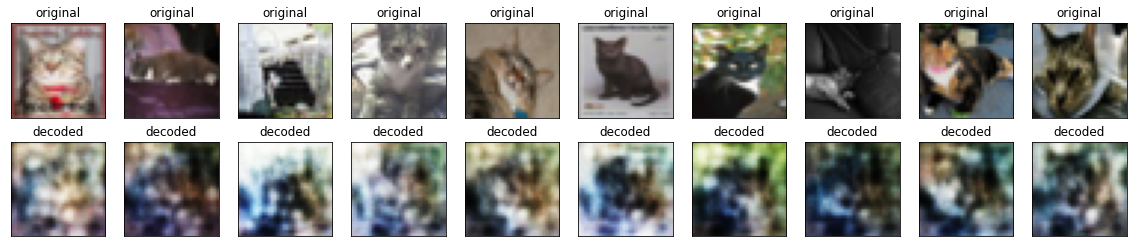

In [ ]:
plot_results(random_test, random_test_decoded4)

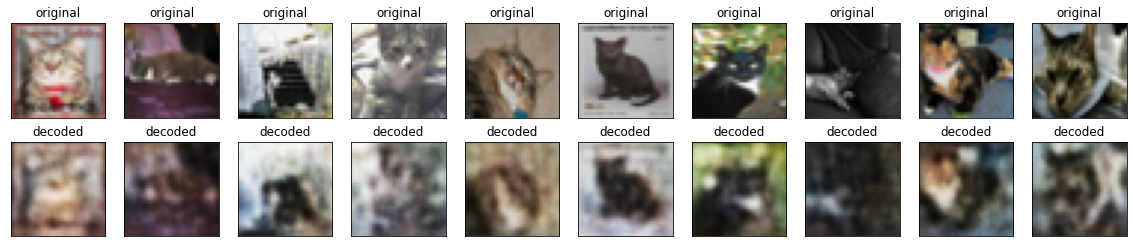

In [ ]:
plot_results(random_test, random_test_decoded5)

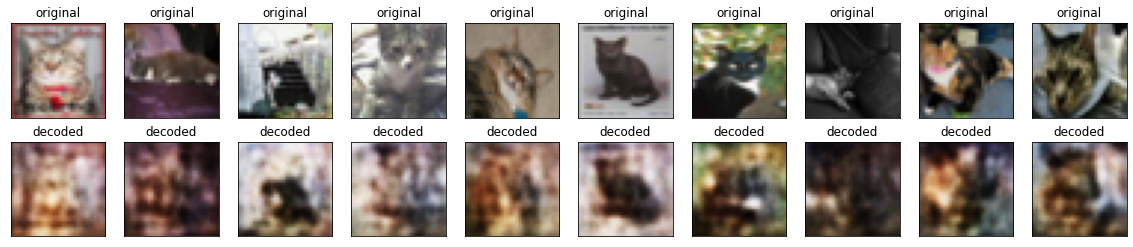

In [ ]:
plot_results(random_test, random_test_decoded6)

Здесь видим, уже видим, что меняется общий тон изображений. В первом случае они более сине-зеленые, во втором случае примерно нормальные, в третьем - более розово-оранжевые

### Вывод

В данной лабораторной работе я реализовал свой автоэнкодер, который учился восстанавливать исходное изображение из его сжатого векторого представления. Результат получился довольно неплохой, но восстановленные изображения немного мыльные. Я думаю, что результат работы автоэнкодера улучшится, если в энкодере и декодере использовать сверточные слои.

Вообще, автоэнкодеры - это очень важный класс нейронных сетей. Он используется для решения многих задач - колоризация, шумоподавление, восстановление изображений, повышение качества итд